<a id="Set_up"></a>
## Setting up Python and Qutip

In [2]:
#Note: You might want to start jupyter with some extra memory capacity to handle the big data sets 
#(the code is not at all optimized and a bit wastefull on memory
#jupyter notebook --NotebookApp.iopub_data_rate_limit=1e10
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from numpy import pi
from numpy import sqrt
from IPython.display import Image
from qutip import *
from qutip.measurement import *
import math

#some parameters
#this is the max amount of photons in a state. length = 5 means each channel has 5 states, so either |0>,|1>,|2>,|3> or |4>
Length = 5  
No_of_channels = 8

# Greenberger-Horne-Zeilinger entanglement
Main reference: Dik Bouwmeester, Jian-Wei Pan, Matthew Daniell, Harald Weinfurter, and Anton Zeilinger
Phys. Rev. Lett. 82, 1345 – Published 15 February 1999

We use Python Qutip to model the setup which was used in ref [xx] to create entanglement between three spatially separated photons. The model is created for fun and to provide some insight, not as fully optimized Python code (disclaimer). The end goal is to mimic the correlation between photon detection events at the single photon detectors which is observed by the authors of the reference article.

This notebook is organized in the following way
1. Definitions and references ([Definitions](#Defs))

2. We set up Python by importing the needed libraries ([Set up](#Set_up))

3. We code some of the 'infrastructure' we need for the modelling ([Infrastructure](#Infra))
    - Measure the 8 channels
    - Model the optical effect of Beamsplittes, Polarizing Beamspliters, Polarizers and half-wave plates
    - Combing the optical components to model the total optical system shown in Figure 1
    - Preparing the vacuum state for 8 channels
    - Define functions for raising/lowering the number of photons in a given channel by 1
    - Running tests with single photons as input to check that the right detector gives a click (to check for errors)
    
4. Running the experiments ([Experiments](#Experiments))
    - Creating two pairs of entangled, indistinguisable photons
    - Filtering out the results where 4 photons are detected by the 4 detectors
    - Evaluating correlation for the 3 situations shown in Figure 2
        - Polarizer in front of D1 at 0 degree (no correlation between D1 and D2 expected)
        - Polarizer in front of D1 at +45 degree (high correlation between D1 and D2 expected)
        - Polarizer in front of D1 at -45 degree (anti-correlation between D1 and D2 expected)

<a id="Defs"></a>
## Definitions and References

### The experiment

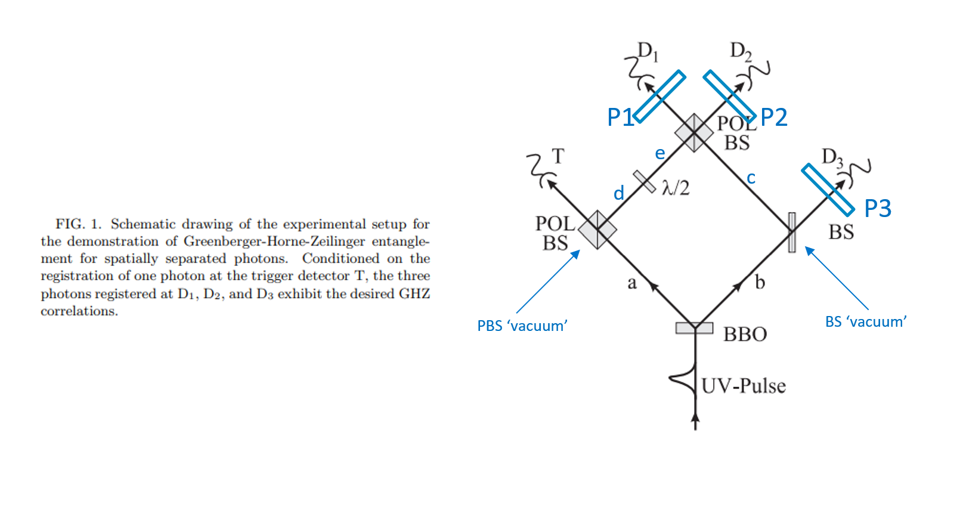

In [3]:
Image(filename='./GHZ-Fig1.png')

Figure 1 is the original sketch from the Bouwmeester article with added some elements to clarify the naming used in this notebook. We will work with a wave function consisting of 8 Fock states representing 4  'spatial channels'. These 4 'spatial channels' carry two channels each (horizontal and vertical polarization), so there are 8 channels in total. Initially these will be 8 vacuum states (i.e., no photons present). Ultimately 4 of these channels will be detected by the detectors (called 'trigger', 'D1', 'D2' and 'D3' by the authors). The other ones are absorbed by the polarizers in front of the detectors, or never populated in the first place (the vertically polarized channel leading to detector 'T' only couples with the vacuum port of the polarizing beamsplitter, so will never carry a photon).

In software we can follow the evolution of the initial state through the system. For this we added the labels 'c', 'd' and 'e' to the spatial channels as indicated in the figure. 

We start with a state in the basis |ah>|av>|bh>|bv>|BSh>|BSv>|PBSh>|PBSv>. Here for instance |ah> represents a Fock state which can contain 0,1,2,3 or 4 photons. Note that these are Fock states and not Qubits. The number represents the number of photons in the state. If we would for instance have state |20000000>, if means two photons in 'channel a' with horizontal polarization. State |00000000> represents the state with all channels in the vacuum states (i.e., no photons).

After the optical system the basis is |Th>|Tv>|D1h>|D1v>|D2h>|D2v>|D3h>|D3v>. The three polarizers then map this on the final basis |Th>|Tv>|D1>|!D1>|D2>|!D2>|!D3>|1D3>. Here Th, D1, D2 and D3 are the signals we are interested in. !D1, !D2 and !D3 represent the photons absorbed in the polarizers and not detected.

Figure 2 (below) indicates the expected correlations

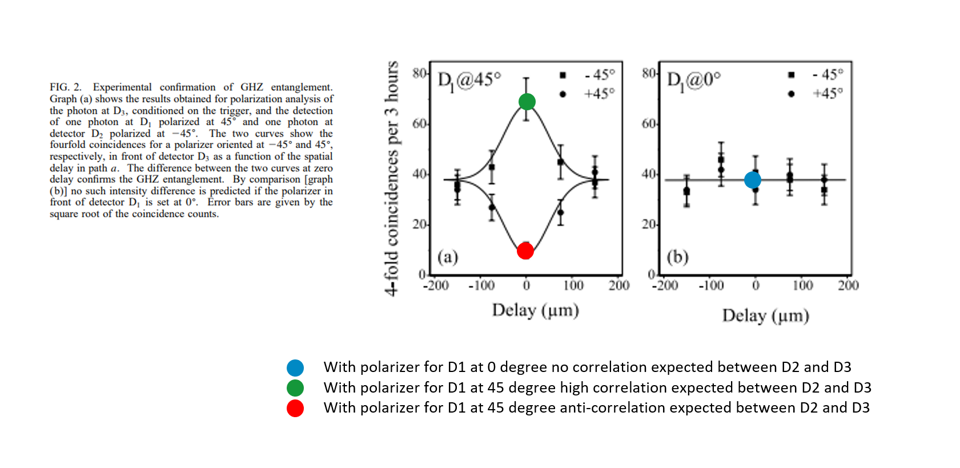

In [4]:
Image(filename='./GHZ-Fig2.png')

### Entanglement

The system start with two pairs of entangled photons in 'channel a' and 'channel b'. for each pair the entangled state is written as:

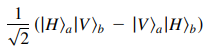

In [5]:
Image(filename='./Eq1-Bouwmeester-PRL-15feb1999.png')

In our code we would write this state as (|10010000> + |01100000>)/sqrt(2) (using basis |ah>|av>|bh>|bv>|BSh>|BSv>|PBSh>|PBSv>).

The resulting GHZ state is written as

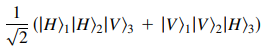

In [6]:
Image(filename='./Eq4-Bouwmeester-PRL-15feb1999.png')

In our code we would write this state as (|10101001> + |10010110>)/sqrt(2) (using basis |Th>|Tv>|D1h>|D1v>|D2h>|D2v>|D3h>|D3v>). Note that we still include the state of trigger channel ('Th') which is not part of the entanglement and could be factored out. The condition for detecting the GHZ state is that a photon in the trigger channel is detected.

Once GHZ state is created the correlation experiment is done. First we project 'channel 1' on an angle of +45 degree by a polarizer. if a photon is detected then the resulting state is written as

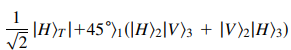

In [7]:
Image(filename='./Eq12-Bouwmeester-PRL-15feb1999.png')

Is our code this would be written as (|10101001> + |10100110>)/sqrt(2) (using basis |Th>|Tv>|D1>|!D1>|D2h>|D2v>|D3h>|D3v>). From basis |D1h>|D1v> to basis |D1>|!D1> we rotated 45 degree to make D1 the polarization orientation to 'pass' the polarizer and !D1 the 'reject' polarization. Clearly now the photons in channel 2 and channel 3 are fully entangled. To the extend that you could consider tracing individual photons in this experiment (which is not the case as they have to be indistinguishable for the GHZ state to be created) the funny consideration is that the photons in channel 2 and channel 3 have to originate from different pairs. The reasoning is that the trigger has to come from an horizontal photon in channel 'a', so its companion has to be vertically polarized. This can either become |D3v> (if it passes through the beamsplitter) or |D2v> (if it is reflected by both the beamsplitter and polarizing beamsplitter). In both cases detectors 2 and 3 detect photons from two different pairs, which are now fully entangled and exhibit the 'spooky action on a distance'. Somehow magically the setup of optical components and measurements generated entanglement between originally not entangled photons.

Now consider the situation where the polarizer in channel 1 is oriented at 0 degree (so passes the 'H' polarization and rejects the 'V' polarization). Then, when a photon is detected we know it was horizontally polarized in channel 1 and the GHZ state has to collaps to horizontal in channel 1 and 2, and vertical in channel 3. In our code we would see the GHZ state (written as (|10101001> + |10010110>)/sqrt(2)) collaps into the state written as |10101001>. There is no entanglement and measuring detector 2 and detector 3 behind 45 degree polarizers should show no correlation.

Of course the modelling below is more complex than needed. Following the logic presented in the Bouwmeester article just mapping 4 input states to 4 output states would be enough. However using using the 8 channels allows to follow more closely what is happening during the transformation step-by-step.

<a id="Infra"></a>
## Infrastructure

### Defining a state

For a single channel the state is defined as a Qutip quantum object. For instance the command to create a state with one photon would be 

'channel_0= basis(5,1)', resulting in Qobj data =[[0][1][0][0][0]], dims = [[5], [1]], shape = (5, 1)

The vacuum state would be created by 'channel_0= basis(5,0)' and have data =[[1][0][0][0][0]] 

In these examples the '5' defines maximum amount of photons that can be carried in the state (so max 4 photons in a state).

The state for 8 channels combined is then created by 
Overall_state = tensor(channel_0, channel_1, channel_2, channel_3, channel_4, channel_5, channel_6, channel_7)

If the size of the individual state is '5' (so max 4 photons in a state) the overall state representing 8 channels has size '5**8 = 390625'

### Define the measurement operators on the 8 channels

In [8]:

def PrintTheState(in_state, N):
    #int N is number of measurements
    #Bool Collapse is whether you collapse the wave function or not
    Collapse = True

    #measurement projection for the single channels
    A,B,C,D,E,F,G,H,Z = [],[],[],[],[],[],[],[],[]

    for i in range(0,Length):
        Z.append(ket2dm(basis(Length,i))) # |i><i|
        
    I = identity(Length)

    #measure first Qubit
    for i in range(0,Length):
        A.append(tensor(Z[i], I, I, I, I, I, I, I))

    #measure other qubits
    for i in range(0,Length):
        B.append(A[i].permute([1, 0, 2, 3, 4, 5, 6, 7]))
        C.append(A[i].permute([2, 1, 0, 3, 4, 5, 6, 7])) 
        D.append(A[i].permute([3, 1, 2, 0, 4, 5, 6, 7])) 
        E.append(A[i].permute([4, 1, 2, 3, 0, 5, 6, 7]))
        F.append(A[i].permute([5, 1, 2, 3, 4, 0, 6, 7]))
        G.append(A[i].permute([6, 1, 2, 3, 4, 5, 0, 7]))
        H.append(A[i].permute([7, 1, 2, 3, 4, 5, 6, 0]))

    PA0 = []
    PB0 = []
    PC0 = []
    PD0 = []
    PE0 = []
    PF0 = []
    PG0 = []
    PH0 = []
    
    for i in range(0,Length):
        PA0.append(A[i])
        PB0.append(B[i])
        PC0.append(C[i])
        PD0.append(D[i])
        PE0.append(E[i])
        PF0.append(F[i])
        PG0.append(G[i])
        PH0.append(H[i])

    for _ in range(0,N):
        value_QB0, out_state = measure(in_state, PA0)
        value_QB1, out_state = measure(out_state, PB0)
        value_QB2, out_state = measure(out_state, PC0)
        value_QB3, out_state = measure(out_state, PD0)
        value_QB4, out_state = measure(out_state, PE0)
        value_QB5, out_state = measure(out_state, PF0)
        value_QB6, out_state = measure(out_state, PG0)
        value_QB7, out_state = measure(out_state, PH0)
        print(value_QB0,value_QB1,value_QB2,value_QB3, value_QB4,value_QB5,value_QB6,value_QB7)
            
    return

In [9]:
def GetMeasurementResult(in_state, N):
    #We use the Qutip function for basic projective measurement by specifying a list of projection operators. 
    #The function requires the input state (given as argument with name in_state) and a list of project operators.
    #Example: if the photon number in a channel is 0,1 or 2 photons we select the projection operators |0⟩⟨0|, |1⟩⟨1| and |2⟩⟨2|
    #==> measure(in_state, [|0⟩⟨0|, |1⟩⟨1|, |2><2|])
    #The result is the index corresponding to the measured value and output state to which the input state has collapsed
 
    #Projector_single_channel is a list which contains the project operators for the photon numbers from 0 to Length-1 for a single channel
    #For Length = 5 (i.e., photon number = 0,1,2,3,4) Projector_single_channel is the list of matrices [|0⟩⟨0|, |1⟩⟨1|, |2⟩⟨2|, |3⟩⟨3|, |4⟩⟨4|]
    
    Projector_single_channel = [] #empty list
    for i in range(0,Length):
         Projector_single_channel.append(ket2dm(basis(Length,i))) # |i><i|
    
    #Extend Projector_single_channel to Projector_first_channel to project on the first channel of a given number of channels by tensor product with the identity operator
    #For 8 channels the project operator on |1><1| in the first channel would be tensor(Projector_single_channel[1], I, I, I, I, I, I, I)
    #Projector_first_channel will be a list of tensor products. 
    #Projector_first_channel still operates on the first channel from the total number of channels (No_of_channels)
    
    Projector_first_channel= [] #empty list
    I = identity(Length)
    for i in range(0,Length):
        List_as_input_for_tensor = [] #empty list
        List_as_input_for_tensor.append(Projector_single_channel[i]) #list with single element
        for j in range(1,No_of_channels):
            List_as_input_for_tensor.append(I) #creating the list [Projector_first_channel[i], I, I, ...]
        Projector_first_channel.append(tensor(List_as_input_for_tensor))
    
    #Projector_first_channel operates on first channel. 
    #To measure the other channels we are rearranging the matrices in the list Projector_first_channel
    #Projector_all_channels[][] will be a list of lists. 
    #Projector_all_channels[0] will be the list of operators for first channel
    #Projector_all_channels[1] will be the list of operators for second channel etc
    #For 8 channels the projection operator on |1><1| in the third channel would be:
    #Projector_all_channels[3][1] = tensor(I, I, Projector_single_channel[1], I, I, I, I, I)
    #We create this by permutation: tensor(Projector_single_channel[1], I, I, I, I, I, I, I).permute([2, 1, 0, 3, 4, 5, 6, 7])
    #So Projector_all_channels[j][i] = tensor(Projector_single_channel[i], I, I, I, I, I, I, I).permute([j,1,2,.. ,jth element = 0, ..])
    #So Projector_all_channels[j][i] = Projector_first_channel[i].permute([j,1,2,.. ,jth element = 0, ..])
    
    Projector_all_channels = [Projector_first_channel] #for first channel we already created the project operators
    for j in range(1,No_of_channels):
        List = list(range(0,No_of_channels)) #create List = [0, 1, 2, ... , No_of_channels-1]
        List[0], List[j] = j, 0 #swap the two elements for the permutation
        P_temp= []
        for i in range(0,Length):
            P_temp.append(Projector_first_channel[i].permute(List))
        Projector_all_channels.append(P_temp)    
    
    #create some space just in case it would be needed
    del P_temp
    del Projector_first_channel
    del Projector_single_channel
    
    #initialize the counters for the series of measurments
    Count_as_event, Count_as_event_notD2, Count_correlation, Count = 0, 0, 0, 0
    HHH,HHV,HVH,VHH,HVV,VHV,VVH,VVV = 0, 0, 0, 0, 0, 0, 0, 0
    
    #initialize the GHZ state as vacuum which will be returned as default when no GHZ state is created 
    GHZ_state = Qobj([[0], [0]])

    #value_QB will be a list containing the measurement results for the channels
    value_QB = [0] * No_of_channels
    
    #Function for easier assessing the measurement result by applying a mask over the array value_QB
    def Mask(pattern, list_of_values):
        if (len(pattern) != No_of_channels) or (len(list_of_values) != No_of_channels):
            print("In the function Mask the size of the pattern or the size of the measured channels do not match with the overall number of channels")
            return 0
        X = 1
        for u in range(0, min(len(pattern),len(list_of_values))):
            if (pattern[u] != list_of_values[u]):
                X=0
        return X #return only 1 if the Mask is identical to the list_of_values
    
    for _ in range(0,N):
        out_state = in_state
        for j in range(0,No_of_channels):
            value_QB[j], out_state = measure(out_state, Projector_all_channels[j])
            if j==1 and (value_QB[0]==1 and value_QB[1]==0):
                temp_state = out_state #temp_state is the state after detecting 1 on Th and 0 on Tv
        Count += 1 #General counter
        #print(value_QB[0],value_QB[1],value_QB[2],value_QB[3],value_QB[4],value_QB[5],value_QB[6],value_QB[7])
        
        #Check for correlations of the permutations H and V for D1,D2 and D3.
        pattern = [1,0,1,0,1,0,1,0]
        if Mask(pattern,value_QB) == 1:
            Count_as_event += 1 #T, D1, D2 and D3 all detect a photon. This is what is detected in the actual experiment
            Count_correlation += 1 #T, D1 detect, and D2 and D3 give the same result. This correlation is a sign of the entanglement
            GHZ_state = temp_state #if we detect the 4 bits then in hindsight the state should have been a GHZ state after trigger detection
        pattern = [1,0,1,0,0,1,0,1]
        if Mask(pattern,value_QB) == 1:
            Count_correlation += 1 #T, D1 detect, and D2 and D3 give the same result (no photon in this case).
        pattern = [1,0,1,0,1,0,0,1]
        if Mask(pattern,value_QB) == 1:
            Count_correlation -= 1 #T, D1 detect, and D2 and D3 give opposite result 
        pattern = [1,0,1,0,0,1,1,0]
        if Mask(pattern,value_QB) == 1:
            Count_correlation -= 1 #T, D1 detect, and D2 and D3 give opposite result 
            Count_as_event_notD2 += 1
        
        #Check for occurences of the permutations H and V for D1,D2 and D3.
        pattern = [1,0,1,0,1,0,1,0] #HHH
        if Mask(pattern,value_QB) == 1:
            HHH += 1 #T, D1 detect, and D2 and D3 give opposite result 
        pattern = [1,0,1,0,1,0,0,1] #HHV
        if Mask(pattern,value_QB) == 1:
            HHV += 1 #T, D1 detect, and D2 and D3 give opposite result 
        pattern = [1,0,1,0,0,1,1,0] #HVH
        if Mask(pattern,value_QB) == 1:
            HVH += 1 #T, D1 detect, and D2 and D3 give opposite result 
        pattern = [1,0,0,1,1,0,1,0] #VHH
        if Mask(pattern,value_QB) == 1:
            VHH += 1 #T, D1 detect, and D2 and D3 give opposite result 
        pattern = [1,0,1,0,0,1,0,1] #HVV
        if Mask(pattern,value_QB) == 1:
            HVV += 1 #T, D1 detect, and D2 and D3 give opposite result 
        pattern = [1,0,0,1,1,0,0,1] #VHV
        if Mask(pattern,value_QB) == 1:
            VHV += 1 #T, D1 detect, and D2 and D3 give opposite result 
        pattern = [1,0,0,1,0,1,1,0] #VVH
        if Mask(pattern,value_QB) == 1:
            VVH += 1 #T, D1 detect, and D2 and D3 give opposite result 
        pattern = [1,0,1,0,0,1,1,0] #HVH
        if Mask(pattern,value_QB) == 1:
            HVH += 1 #T, D1 detect, and D2 and D3 give opposite result 
        pattern = [1,0,0,1,1,0,1,0] #VHH
        if Mask(pattern,value_QB) == 1:
            VHH += 1 #T, D1 detect, and D2 and D3 give opposite result 
        pattern = [1,0,0,1,0,1,0,1] #VVV
        if Mask(pattern,value_QB) == 1:
            VVV += 1 #T, D1 detect, and D2 and D3 give opposite result 
    Occurences = [HHH,HHV,HVH,VHH,HVV,VHV,VVH,VVV]
    
    Result = {'Count': Count, 'Count_as_event': Count_as_event, 'Count_as_event_notD2': Count_as_event_notD2, 'Count_correlation': Count_correlation, 'GHZ_state': GHZ_state, 'Occurences':Occurences, 'Occurences_order':'HHH,HHV,HVH,VHH,HVV,VHV,VVH,VVV'}
    
    return Result

### Make the generic swap operator for two channels

This operator is used when two channels are swapped. The idea is to transfer state |n>|m>|0>|0> to |0>|0>|m>|n>, with last two states representing output (initially empty) and the first two states represent input (empty after operation has been executed). For efficiency we map in our code the output on the input, so from |n>|m> to |m>|n>. This is a straightforward operation, only complicated by the way data is stored in the Qupit Qobj 'data' attribute.

For qubit this would be the X-gate, or for spins the Pauli x matrix. These have only off-diagonal 1's and 0's on the diagonal. In this code we represent the state as a linear array of 1's and 0's so correct packing and unpacking needs to happen to swap states in the right way. Code is not optimized for efficiency.

In [10]:
Data = np.zeros((Length**2,Length**2))
for i in range(0,Length**2):
    x = i%Length
    y = int((i-x)/Length)
    j = y + Length * x
    Data[i,int(j)] = 1
Swap2 = Qobj(Data,[[Length, Length], [Length, Length]], shape = (Length**2, Length**2))
#Note, this is for two channels, needs extension for full basis

### Make the generic mixing operator for two channels
The mixing operator mixes two channels to simulate the effect of the 50%-50% beamsplitter or the half-wave plate. There is quite some quantum magic in this operator and some nice tutorials to be found on-line

Check for instance:
- https://www.pas.rochester.edu/~howell/mysite2/Tutorials/Beamsplitter2.pdf
- https://arxiv.org/pdf/quant-ph/0106136.pdf (Phys. Rev. A 65, 032323 – Published 27 February 2002)

The mathematics used is based on the description found in https://physics.stackexchange.com/a/207139, copied below

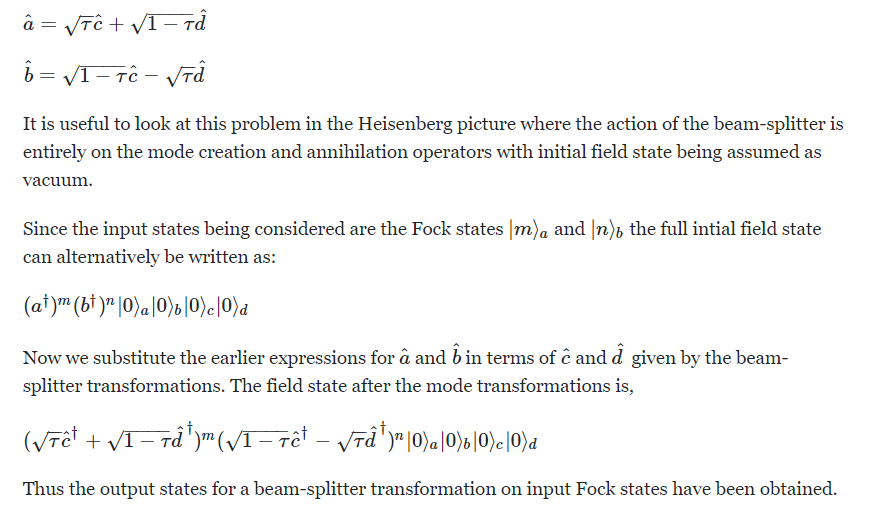

In [11]:
Image(filename='./BeamSplitterExplanation.png')

In [12]:
#mix two channels 
Data = np.zeros((Length**2,Length**2)) # Data for Qobj operator to model the mixing
r = 1/sqrt(2)
t = 1/sqrt(2)
for l1 in range(0,Length**2):
    n = int(l1%Length)
    m = int((l1-n)/Length)
    #n and m are input photon numbers, l1 is the counter for output data. l1 = m * Length + n
    #the input is a state |n>|m> . The mixing has a transmission (t) and a reflection (r)
    #the matrix is [t,r],[r,-t]. Output is a sum of states |u>|v>
    #so transformation is  |n>|m>|0>|0>  to (a**n)(b**m)|0>|0>|0>|0> to  Sum((c**u)(d**v)|0>|0>|0>|0>) to Sum(|0>|0>|u>|v>)
    #(tu + rv)**n (ru - tv)**m = 
    for i in range(0,n+1):
        for j in range(0,m+1):
            u = (n+m) - (i+j)
            v = (i+j)
            #the factor from the binomial expansion
            coeff = math.comb(n,i)*math.comb(m,j)*(r**(n-i))*(t**(m-j))*(t**(i))*((-r)**(j))
            #factor in sqrt n for boson raising operation c|n> = sqrt(n+1)|n+1> and l|n> = sqrt(n)|n-1>. <n|a*a|n> = n
            coeff = coeff * sqrt(math.factorial(u)*math.factorial(v)/(math.factorial(n)*math.factorial(m)))
            #total number of photons cannot exceed (length-1) for each of the output channels
            if ((u < Length) and (v < Length)):
                l2 = v * Length + u
                Data[l1,l2] = Data[l1,l2] + coeff
Mix2 = Qobj(Data,[[Length, Length], [Length, Length]], shape = (Length**2, Length**2))
#Note, this is for two channels, needs extension for full basis via a tensor product

### Model the optical system transferring the input state to the 8 output channels (horizontal/vertical polarization for detectors T, D1, D2, D3)

In [13]:
#Start with identity matrix
I = identity(Length)
Matrix = tensor(I, I, I, I, I, I, I, I)
#print(Matrix)

#Matrix for mixing first two channels
Mix = tensor(Mix2, I, I, I, I, I, I)
#Mix = Qobj(Mix.data.toarray().reshape((256,256)),[[4, 4, 4, 4, 4, 4, 4, 4], [4, 4, 4, 4, 4, 4, 4, 4]], shape = (65536, 65536))
#Matrix for swapping first two channels
Swap = tensor(Swap2, I, I, I, I, I, I)
#Swap = Qobj(Swap.data.toarray().reshape((256,256)),[[4, 4, 4, 4, 4, 4, 4, 4], [4, 4, 4, 4, 4, 4, 4, 4]], shape = (65536, 65536))

#[0, 1, 2, 3, 4, 5, 6, 7]
#start with order of basis ah,av,bh,bv,BSh,BSv,PBSh,PBSv
#Step 1: Mix bh(2) and BSh(4)
Matrix = Mix.permute([2, 4, 0, 3, 1, 5, 6, 7]) * Matrix

#Step 2: Mix bv(3) and BSv(5)
Matrix = Mix.permute([3, 5, 2, 0, 4, 1, 6, 7]) * Matrix
#order of basis is now ah,av,ch,cv,D3h,D3v,PBSh,PBSv, we have modelled the effect of the BS in path 'b'

#Step 3: Swap PBSv(7) and av(1)
Matrix = Swap.permute([7, 1, 2, 3, 4, 5, 6, 0]) * Matrix
#order of basis is now Th,Tv,ch,cv,D3h,D3v,dh,dv, we have modelled the effect of the PBS in path 'a'

#Step 4: Mix dh(6) and dv(7)
Matrix = Mix.permute([6, 7, 2, 3, 4, 5, 0, 1]) * Matrix
#order of basis is now Th,Tv,ch,cv,D3h,D3v,eh,ev we have modelled the effect of the halve wave plate in path 'd'

#Step 5: Swap cv(3) and ev(7)
Matrix = Swap.permute([3, 7, 2, 0, 4, 5, 6, 1]) * Matrix
#order of basis is now Th,Tv,D1h,D1v,D3h,D3v,D2h,D2v we have modelled the effect of the PBS path 'e' and 'c'

#Step 5: Swap D3h(4) and D2h(6)
Matrix = Swap.permute([4, 6, 2, 3, 0, 5, 1, 7]) * Matrix
#order of basis is now Th,Tv,D1h,D1v,D2h,D3v,D3h,D2v 

#Step 5: Swap D3v(5) and D2v(7)
Matrix = Swap.permute([5, 7, 2, 3, 4, 0, 6, 1]) * Matrix
#order of basis is now Th,Tv,D1h,D1v,D2h,D2v,D3h,D3v 

#We have ordered the detectors T,D1,D2,D3 with always first channel h-polarized
#The way to model this system is Output_state = Matrix * Input_state


### Define the input state vector in vacuum state

We want to create the state with all 8 channels having 0 photons |00000000>

In [14]:
#define 8 channels without entanglement as a tensor product of separate channels
#The order is "ah,av,bh,bv,BSh,BSv,PBSh,PBSv"
Vac = basis(Length,0)
#define vacuum state for 8 channels
Vacuum_state = tensor(Vac, Vac, Vac, Vac, Vac, Vac, Vac, Vac)

### Define functions to increase or decrease the photon number in a given channel by 1

Note that these function just increase or decrease the photon number by one. They do not do any normalization or include the scaling of the creation and annihilation operators of the quantum harmonic oscillator. So applying 'Raise_state' on a state with 2 photons |2> would create a state with 3 photons |3> without the usual sqrt(3).

In [15]:

def Raise_state(n):
    I = identity(Length)
    List = [0, 1, 2, 3, 4, 5, 6, 7]
    List[0] = n
    List[n] = 0
    Data = np.zeros((Length,Length))
    for i in range(0,Length-1):
        Data[i+1,i] = 1
    Raise_operator = tensor(Qobj(Data,[[Length], [Length]], shape = (Length, Length)), I, I, I, I, I, I, I).permute(List)
    return Raise_operator

def Lower_state(n):
    I = identity(Length)
    List = [0, 1, 2, 3, 4, 5, 6, 7]
    List[0] = n
    List[n] = 0
    Data = np.zeros((Length,Length))
    for i in range(0,Length-1):
        Data[i,i+1] = 1
    Lower_operator = tensor(Qobj(Data,[[Length], [Length]], shape = (Length, Length)), I, I, I, I, I, I, I).permute(List)
    return Lower_operator


### Test the system with single photons

First show the effect of the raising operators on the vacuum state.

In [16]:
print("at inputside the order of the channels is ah,av,bh,bv,BSh,BSv,PBSh,PBSv")
print("Raise the state of the first channel, ah")
PrintTheState(Raise_state(0) *Vacuum_state,1)
print("Raise the state of the 8th channel, PBSv")
PrintTheState(Raise_state(7) *Vacuum_state,1)
print("Raise the state of the 3rd channel twice channel, bh")
PrintTheState(Raise_state(2) *Raise_state(2) *Vacuum_state,1)
print("Raise the state of the 4th channel (bv) and the 5th channel (BSh)")
PrintTheState(Raise_state(3) *Raise_state(4) *Vacuum_state,1)
print("we can also create a superposition which gives different results per measurement")
for _ in range(0,10):
    PrintTheState((1/sqrt(2))*(Raise_state(3) *Raise_state(3)* Vacuum_state + Vacuum_state),1)
print("Or we can also create a entangled state")
for _ in range(0,10):
    PrintTheState((1/sqrt(2))*(Raise_state(3)* Vacuum_state +  Raise_state(2)*Vacuum_state),1)

at inputside the order of the channels is ah,av,bh,bv,BSh,BSv,PBSh,PBSv
Raise the state of the first channel, ah
1 0 0 0 0 0 0 0
Raise the state of the 8th channel, PBSv
0 0 0 0 0 0 0 1
Raise the state of the 3rd channel twice channel, bh
0 0 2 0 0 0 0 0
Raise the state of the 4th channel (bv) and the 5th channel (BSh)
0 0 0 1 1 0 0 0
we can also create a superposition which gives different results per measurement
0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0
0 0 0 2 0 0 0 0
0 0 0 2 0 0 0 0
0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0
0 0 0 2 0 0 0 0
0 0 0 2 0 0 0 0
0 0 0 2 0 0 0 0
Or we can also create a entangled state
0 0 0 1 0 0 0 0
0 0 1 0 0 0 0 0
0 0 0 1 0 0 0 0
0 0 0 1 0 0 0 0
0 0 0 1 0 0 0 0
0 0 1 0 0 0 0 0
0 0 0 1 0 0 0 0
0 0 1 0 0 0 0 0
0 0 0 1 0 0 0 0
0 0 0 1 0 0 0 0


Before running the experiment we test the matrix for single photons in one of the input channels to check if they give the expected outcome.

perform some checks
1. If input state is only 'ah' then only 'Th' should be populated 100%, rest should be zero
Result: ok.
2. If input state is only 'PBSv' then only 'Tv' should be populated 100%, rest should be zero
Result: ok.
3. If input is only 'bh' then 'D3h' should be populated 50% and 'D1h' the other 50%
Result: ok.
4. If input is only 'bv' then 'D3v' should be populated 50% and 'D2v' the other 50%
Result: ok.
5. If input is only 'BSh then 'D3h' should be 1 50% of time and 'D1h' the other 50%
Result: ok.
6. If input is only 'BSv' then 'D3v' should be 1 50% of time and 'D2v' the other 50%
Result: ok.
7. If input is only 'PBSh' then 'D2h' should be 1 50% of time and 'D1v' the other 50%
Result: ok.
7. If input is only 'av' then 'D2h' should be 1 50% of time and 'D1v' the other 50%
Result: ok.

In [17]:
#test case 3: If input is only 'bh' then 'D3h' should be populated 50% and 'D1h' the other 50% Result: ok
#The order for input is "ah,av,bh,bv,BSh,BSv,PBSh,PBSv"
PrintTheState(Matrix * Raise_state(2) *Vacuum_state, 10)
#order of basis for output is Th,Tv,D1h,D1v,D2h,D2v,D3h,D3v 

0 0 0 0 0 0 1 0
0 0 0 0 0 0 1 0
0 0 0 0 0 0 1 0
0 0 0 0 0 0 1 0
0 0 1 0 0 0 0 0
0 0 1 0 0 0 0 0
0 0 0 0 0 0 1 0
0 0 1 0 0 0 0 0
0 0 1 0 0 0 0 0
0 0 1 0 0 0 0 0


<a id="Experiments"></a>
## Experiments

### Create the input state consisting of two pairs of entangled photons

In [18]:
#start by creating one pair of entangled photons in spatial channels a and b, with opposite polarization
input_state = (1/sqrt(6))*(Raise_state(0)*Raise_state(3) + Raise_state(1)*Raise_state(2))*Vacuum_state
#add another pair of entangled photons in spatial channels a and b, with opposite polarization
input_state = (1)*(Raise_state(0)*Raise_state(3) + Raise_state(1)*Raise_state(2))*input_state

#check whether state is normalized correctly: 'print(input_state.dag() * input_state)'should yield '1'
#print(input_state.dag() * input_state)

print("The order of the result is: ah,av,bh,bv,BSh,BSv,PBSh,PBSv")
print("Each pair alone should yield result (1 0 0 1 0 0 0 0) or (0 1 1 0 0 0 0 0)")
print("The two pairs combined should yield (2 0 0 2 0 0 0 0), (0 2 2 0 0 0 0 0) or (1 1 1 1 0 0 0 0)")
PrintTheState(input_state, 10)

The order of the result is: ah,av,bh,bv,BSh,BSv,PBSh,PBSv
Each pair alone should yield result (1 0 0 1 0 0 0 0) or (0 1 1 0 0 0 0 0)
The two pairs combined should yield (2 0 0 2 0 0 0 0), (0 2 2 0 0 0 0 0) or (1 1 1 1 0 0 0 0)
1 1 1 1 0 0 0 0
1 1 1 1 0 0 0 0
1 1 1 1 0 0 0 0
1 1 1 1 0 0 0 0
1 1 1 1 0 0 0 0
1 1 1 1 0 0 0 0
1 1 1 1 0 0 0 0
0 2 2 0 0 0 0 0
1 1 1 1 0 0 0 0
1 1 1 1 0 0 0 0


### With polarizers at 45degree we should see high correlation between D2 and D3 for given D1

In [19]:
#we build on the 'Matrix'modelling the optical system by adding the impact of the polarizers
#Step 6: Polarizer in front of D1 at 45 degree
Matrix2 = Mix.permute([2, 3, 0, 1, 4, 5, 6, 7]) * Matrix
#order of basis is now Th,Tv,D1+,D1-,D2h,D2v,D3h,D3v 

#Step 7: Polarizer in front of D2 at -45 degree
Matrix2 = Mix.permute([4, 5, 2, 3, 1, 0, 6, 7]) * Matrix2
#order of basis is now Th,Tv,D1+,D1-,D2-,D2+,D3h,D3v 

#Step 8: Polarizer in front of D3 at +45 degree
Matrix2 = Mix.permute([6, 7, 2, 3, 4, 5, 0, 1]) * Matrix2
#order of basis is now Th,Tv,D1+,D1-,D2-,D2+,D3-,D3v+ 
#PrintTheState(Matrix * result_state)
output_state = Matrix2 * input_state


In [20]:
Result_D1_45 = GetMeasurementResult(output_state, 100)

### With D1 at 0 deg no correlation between D2 and D3 for given D1

In [21]:
#we build on the 'Matrix'modelling the optical system by adding the impact of the polarizers

#Step 6: Polarizer in front of D1 at 0 degree ==> no change
#Do not touch D1h and D1v
#order of basis is now Th,Tv,D1h,D1v,D2h,D2v,D3h,D3v 

#Step 7: Polarizer in front of D2 at -45 degree
Matrix2 = Mix.permute([4, 5, 2, 3, 1, 0, 6, 7]) * Matrix
#order of basis is now Th,Tv,D1h,D1v,D2-,D2+,D3h,D3v 

#Step 8: Polarizer in front of D3 at +45 degree
Matrix2 = Mix.permute([6, 7, 2, 3, 4, 5, 0, 1]) * Matrix2
#order of basis is now Th,Tv,D1h,D1v,D2-,D2+,D3-,D3v+ 
#PrintTheState(Matrix * result_state)
output_state = Matrix2 * input_state

In [22]:
Result_D1_0 = GetMeasurementResult(output_state, 100)

### Result:


In [23]:
print("Total number of experiments executed with polarizer D1 at +0 degrees:", Result_D1_0.get('Count'))
print("Total number of experiments executed with polarizer D1 at +45 degrees:", Result_D1_45.get('Count'))
print("----------------")
print("For the polarizer in front of D1 oriented at +45 the result is:")
print("D2 at -45 and D3 at +45: ",Result_D1_45.get('Count_as_event'))
print("D2 at +45 and D3 at +45: ",Result_D1_45.get('Count_as_event_notD2'))
print("For D2 at -45 the count where D2 and D3 register the same, minus when the register opposite: ",Result_D1_45.get('Count_correlation'))
print("----------------")
print("Then for the polarizer in front of D1 oriented at 0 degree the result is:")
print("D2 at -45 and D3 at +45: ",Result_D1_0.get('Count_as_event'))
print("D2 at +45 and D3 at +45: ",Result_D1_0.get('Count_as_event_notD2'))
print("For D2 at -45 the count where D2 and D3 register the same, minus when the register opposite: ",Result_D1_0.get('Count_correlation'))



Total number of experiments executed with polarizer D1 at +0 degrees: 100
Total number of experiments executed with polarizer D1 at +45 degrees: 100
----------------
For the polarizer in front of D1 oriented at +45 the result is:
D2 at -45 and D3 at +45:  6
D2 at +45 and D3 at +45:  0
For D2 at -45 the count where D2 and D3 register the same, minus when the register opposite:  12
----------------
Then for the polarizer in front of D1 oriented at 0 degree the result is:
D2 at -45 and D3 at +45:  2
D2 at +45 and D3 at +45:  7
For D2 at -45 the count where D2 and D3 register the same, minus when the register opposite:  -2


### Experimental Results

Total number of experiments executed with polarizer D1 at +0 degrees: 1000

Total number of experiments executed with polarizer D1 at +45 degrees: 1000

----------------
For the polarizer in front of D1 oriented at +45 the result is:

D2 at -45 and D3 at +45:  47

D2 at +45 and D3 at +45:  0

For D2 at -45 the count where D2 and D3 register the same, minus when the register opposite:  83

-------------------

Then for the polarizer in front of D1 oriented at 0 degree the result is:

D2 at -45 and D3 at +45:  22

D2 at +45 and D3 at +45:  25

For D2 at -45 the count where D2 and D3 register the same, minus when the register opposite:  0

==> This replicates the results from the Bouwmeester article where we see with D1@45 a high count for the situation with D2 and D3 orthogonal, and a very low count for D2 and D3 in the same direction (article opposite). The proof of entanglement is that this correlation disappears if we move the polarizer in front of D1@0 degree

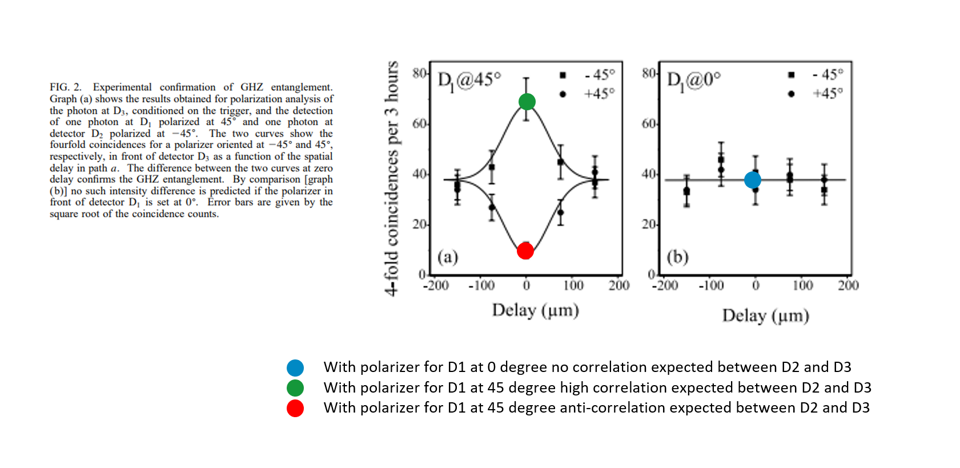

In [24]:
Image(filename='./GHZ-Fig2.png')

### We see the correlation, but did we create an GHZ state?

One other argument given in the article is that when we detect a photon in the Trigger channel the detector D1, D2 and D3 only observe H1H2V3 and V1V2H3 and not any of the other 6 combinations. In our code this means we only observe 10101001 or 10010110 and not for instance 10101010 (corresponding to H1H2H3) or 10010101 (corresponding to V1V2V3). Let's check:

In [25]:
Result_coincidence = GetMeasurementResult(Matrix * input_state, 100)

In [26]:
print("The order of the occurences reported back is ", Result_coincidence.get('Occurences_order'))
print(Result_coincidence.get('Occurences'))

The order of the occurences reported back is  HHH,HHV,HVH,VHH,HVV,VHV,VVH,VVV
[0, 9, 0, 0, 0, 0, 9, 0]


The only detected components are HHV and VVH, so one could conclude that the state indeed is |T>(|HHV> + |VVH>). In that case the projection of the out_put state on the GHZ_state should be 1:

|<GHZ|output_state>|**2 = 1

In [27]:
GHZ_state_HHV = Raise_state(0) * Raise_state(2) * Raise_state(4) * Raise_state(7) * Vacuum_state
GHZ_state_VVH = Raise_state(0) * Raise_state(3) * Raise_state(5) * Raise_state(6) * Vacuum_state
output_state = Matrix * input_state
GHZ_state = (1/sqrt(2))*(GHZ_state_HHV + GHZ_state_VVH )
print("Project on GHZ state", ((GHZ_state.dag() * output_state).tr())**2)
#Project on GHZ state 0.16666666666666663
print("The trace of (density matrix)**2 for the output_state is", (ket2dm(output_state)*ket2dm(output_state)).tr())

Project on GHZ state 0.16666666666666663
The trace of (density matrix)**2 for the output_state is 1.0000000000000002


So on 16% of the state produced by the optical setup is actually the GHZ state, the remaining 84% consists of other components. We can check what these components are by projecting on all possible states that have photon number 4 (including states where certain modes are occupied by 2 or 3 photons). We loop to all options and only provide the combinations that have a non-zero contribution. The state is a pure quantum state and not a mixture

In [28]:
GHZ = Matrix * input_state
norm = 0
print("components of the quantum state represented in how 4 photons are distributed")
print("0 0 3 4 means two photons in channel 0 and one in channels 3 and 4 each")
for a in range(0,8):
    for b in range (a,8):
        for c in range (b,8):
            for d in range (c,8):
                Project_state = Raise_state(d) * Raise_state(a) * Raise_state(b) * Raise_state(c) * Vacuum_state
                p = (Project_state.dag() * GHZ).tr()
                if p != 0:
                    print(a,b,c,d,":","%.2f" % p,"%.2f" % p**2)
                    norm += p**2
print("norm", norm)

components of the quantum state represented in how 4 photons are distributed
0 0 3 4 means two photons in channel 0 and one in channels 3 and 4 each
0 0 5 5 : 0.20 0.04
0 0 5 7 : -0.29 0.08
0 0 7 7 : 0.20 0.04
0 2 3 5 : 0.29 0.08
0 2 3 7 : -0.29 0.08
0 2 4 5 : 0.29 0.08
0 2 4 7 : -0.29 0.08
0 3 5 6 : -0.29 0.08
0 3 6 7 : 0.29 0.08
0 4 5 6 : -0.29 0.08
0 4 6 7 : 0.29 0.08
2 2 3 3 : 0.10 0.01
2 2 3 4 : 0.14 0.02
2 2 4 4 : 0.10 0.01
2 3 3 6 : -0.14 0.02
2 3 4 6 : -0.20 0.04
2 4 4 6 : -0.14 0.02
3 3 6 6 : 0.10 0.01
3 4 6 6 : 0.14 0.02
4 4 6 6 : 0.10 0.01
norm 1.0


So clearly the state contains many more components next to the GHZ components. Only if we exclusively evaluate components which contain 1 photon in channels 0 or 1, 1 photon in 2 or 3, 1 photon in 4 or 5 and 1 photon in 6 or 7 (so in view of the experiment have 1 photon detected by each detector) we have left the combinations 0247 (|THHV>) and 0356 (|TVVH>). So indeed exclusively looking at occassions where each detector detects one photon gives the correct correlations, corresponding to a GHZ state, but before the measurement the state is not a pure GHZ state. After measurement the state is collapsed to one of the components corresponding to measurement result.

In [29]:
#we can also take partial traces to see the state of every individual channel. Also here we see the states with more than one photon back

for j in range(0,8):
    print(GHZ.ptrace(j))


Quantum object: dims = [[5], [5]], shape = (5, 5), type = oper, isherm = True
Qobj data =
[[0.16666667 0.         0.         0.         0.        ]
 [0.         0.66666667 0.         0.         0.        ]
 [0.         0.         0.16666667 0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]]
Quantum object: dims = [[5], [5]], shape = (5, 5), type = oper, isherm = True
Qobj data =
[[1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
Quantum object: dims = [[5], [5]], shape = (5, 5), type = oper, isherm = True
Qobj data =
[[0.54166667 0.         0.         0.         0.        ]
 [0.         0.41666667 0.         0.         0.        ]
 [0.         0.         0.04166667 0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]]
Quantum object: dims = [[5], [5]], shape = (5, 5), type =

In [30]:
#mapping on all states with one photon per detector again confirms that for this condition only two components contribute.
GHZ = Matrix * input_state
Project_state = Raise_state(0) * Raise_state(2) * Raise_state(4) * Raise_state(6) * Vacuum_state
print("HHH", (Project_state.dag() * GHZ).tr())
Project_state = Raise_state(0) * Raise_state(2) * Raise_state(4) * Raise_state(7) * Vacuum_state
print("HHV", (Project_state.dag() * GHZ).tr())
Project_state = Raise_state(0) * Raise_state(2) * Raise_state(5) * Raise_state(6) * Vacuum_state
print("HVH", (Project_state.dag() * GHZ).tr())
Project_state = Raise_state(0) * Raise_state(3) * Raise_state(4) * Raise_state(6) * Vacuum_state
print("VHH", (Project_state.dag() * GHZ).tr())
Project_state = Raise_state(0) * Raise_state(2) * Raise_state(5) * Raise_state(7) * Vacuum_state
print("HVV", (Project_state.dag() * GHZ).tr())
Project_state = Raise_state(0) * Raise_state(3) * Raise_state(4) * Raise_state(7) * Vacuum_state
print("VHV", (Project_state.dag() * GHZ).tr())
Project_state = Raise_state(0) * Raise_state(3) * Raise_state(5) * Raise_state(6) * Vacuum_state
print("VVH", (Project_state.dag() * GHZ).tr())
Project_state = Raise_state(0) * Raise_state(3) * Raise_state(5) * Raise_state(7) * Vacuum_state
print("VVV", (Project_state.dag() * GHZ).tr())


HHH 0.0
HHV -0.28867513459481287
HVH 0.0
VHH 0.0
HVV 0.0
VHV 0.0
VVH -0.28867513459481287
VVV 0.0
